# Travelling Salesman Evolutionary Algorithm

This notebook covers my implementation and testing of an evolutionary algorithm to solve the travelling salesmen algorithm.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import random
import heapq
import seaborn as sns
import timeit
sns.set(rc={'figure.figsize':(20,10)})
group = []

## Functions

Below are all the functions used to construct the evolutionary algorithm.

### Helper Functions

In [2]:
def generator(matrix, initilisation):
    """
    Function takes a list and a adjacency martrix and produces a path containing all the edges and the weight 
    of that path as a tuple
    """
    n = len(matrix)
    edges = [x for x in range(n)]
    #initialising a solution with all nodes in a random shuffled order
    random.shuffle(edges)
    cost = 0
    for i in range(len(edges)-1):
        cost += matrix[edges[i]][edges[i+1]]
    cost += matrix[edges[-1]][edges[0]]
    initilisation.append((edges, cost))
    return initilisation

In [3]:
def calculate_cost(path, matrix):
    """
    Helper function that evaluates the cost of a path given its associated adjacency matrix and returns a tuple 
    of the path and weight
    """
    cost = 0
    for i in range(len(path)-1):
        cost += matrix[path[i]][path[i+1]]
    cost += matrix[path[-1]][path[0]]
    return (path, cost)

### Functions

In [4]:
def create_initial_populations(filename, population_size):
    """
    Function takes a file and a population size and generates the adjacency matrix from the file 
    and a population of valid paths and their associated weights as a tuple
    """
    #reading xml file
    tree = ET.parse(filename)
    root = tree.getroot()
    matrix = []
    #creating the adjacency matrix
    for start_node, edge in enumerate(root.iter('vertex')):
        row = []
        for end_node, weight in enumerate(edge):
            if start_node == end_node:
                 row.append(0)
            row.append(float(weight.get("cost")))
        matrix.append(row)
    matrix[-1].append(0)
    initilisation = []
    #using the helper function to generate initial paths to make up the population
    for i in range(population_size):
           initilisation =  generator(matrix, initilisation)
    return initilisation, matrix

In [271]:
def tournament_selection(population, tournament_size):
    """
    Function that takes a population and a tournament size, picks the tournament size of random paths from the 
    population, compares all of them and returns the path with the lowest cost. If there is a tie one of the 
    paths is chosen at random.
    """
    tournament = []
    winner = (None, float('inf'))
    #take a random selection of the population
    selection = random.sample(range(0,len(population)), tournament_size)
    for i in selection:
        tournament.append(population[i])
    #find the path with the smallest cost
    for i in tournament:
        if i[1] < winner[1]:
            winner = i
        elif i[1] == winner[1]:
            if random.randint(0,1) == 0:
                winner = i
    return winner

In [6]:
def select_parents(population, tournament_size):
    """
    Function that performs the tournament selection twice to produce two parent, a and b.
    """
    a = tournament_selection(population, tournament_size)
    b = tournament_selection(population, tournament_size)
    return a, b

In [7]:
def crossover_with_fix(a,b, matrix):
    """
    Function takes 2 parents a and b and the associated adjacency matrix. It performs a single point crossover 
    based on a random variable, then in order to make the children valid any duplicates at the start of the list
    are replaced by the values not contained in the path based on the order they appear in the other parent. 
    Returns 2 children c and d.
    """
    #swapping values after a certain point
    k = random.randint(1,(len(a[0])-1))
    for i in range(k, len(a[0])):
        a[0][i], b[0][i] = b[0][i], a[0][i]
    missing1 = []
    missing2 = []
    
    #finding all values missing in the list
    for i in [(x) for x in range(len(a[0]))]:
        if i not in a[0]:
            missing1.append(i)
    oc_set = set()
    res = []
    #finding the index for all the duplicate values
    for idx, val in enumerate(a[0]):
        if val not in oc_set:
            oc_set.add(val)         
        else:
             res.append(idx)
    #updating the list
    for i in range(len(res)):
        a[0][res[i]] = missing1[i]
    
    #finding all values missing in the list
    for j in [(x) for x in range(len(b[0]))]:
        if j not in b[0]:
            missing2.append(j)
    oc_set = set()
    res = []
    #finding the index for all the duplicate values
    for idx, val in enumerate(b[0]):
        if val not in oc_set:
            oc_set.add(val)         
        else:
            res.append(idx)
    #updating the list
    for j in range(len(res)):
        b[0][res[j]] = missing2[j]
        
    #calculating the cost of each of the paths
    c = calculate_cost(a[0], matrix)
    d = calculate_cost(b[0], matrix)
    #checking each path contains every node
    assert len(set(c[0])) == len(c[0])
    assert len(set(d[0])) == len(d[0])
    return c, d

In [286]:
def ordered_crossover(a,b,matrix):
    """
     Function takes 2 parent and its associated adjacency matrix, it then appends the a the first k values to the 
     child and then the rest of the path is built using the order of the missing values in the other child to the 
     first half being appended to the path.
     Returns two children c and d.
    """
    c_path = []
    d_path = []
    missing1 = []
    missing2 = []
    order1 = []
    order2 = []
    k = random.randint(1,(len(a[0])-1))
    for i in range(0,k):
        c_path.append(a[0][i])
        d_path.append(b[0][i])
    #adding the first section of the path
    for i in [(x) for x in range(len(a[0]))]:
        if i not in c_path:
            missing1.append(i)
    
    for j in missing1:
        order1.append(b[0].index(j))
    zipped1 = zip(missing1, order1)
    res1 = sorted(zipped1, key = lambda x: x[1])
    #adding the rest of the values in the order based off b
    for i in res1:
        c_path.append(i[0])
    assert len(c_path) == len(a[0])
    #adding the first section of the path
    for i in [(x) for x in range(len(b[0]))]:
        if i not in d_path:
            missing2.append(i)
    
    for j in missing2:
        order2.append(a[0].index(j))
    zipped2 = zip(missing2, order2)
    res2 = sorted(zipped2, key = lambda x: x[1])
    #adding the rest of the values in the order based off a
    for i in res2:
        d_path.append(i[0])
    assert len(d_path) == len(b[0])
    c = calculate_cost(c_path, matrix)
    d = calculate_cost(d_path, matrix)
    assert(len(set(c_path)) == len(c_path))
    assert(len(set(d_path)) == len(d_path))
    return c,d

In [9]:
def single_swap_mutation(solution, matrix):
    """
    Function that swaps 2 genes within a path then calculates the new cost of the path and returns a path and cost
    tuple.
    """
    #generating random values to swap nodes
    swap_to = random.randint(0,len(solution[0])-1)
    swap_from = random.randint(0,len(solution[0])-1)
    solution[0][swap_to], solution[0][swap_from] = solution[0][swap_from], solution[0][swap_to]
    mutation = calculate_cost(solution[0], matrix)
    assert len(set(solution[0])) == len(solution[0])
    return mutation

In [10]:
def inversion_mutation(solution, matrix):
    """
    Function that inverses a path then calculates the new cost of the path an returns a path and cost tuple.
    """
    child = solution[0][::-1]
    mutation = calculate_cost(child, matrix)
    return mutation

In [11]:
def multi_swap_mutation(solution, no_swaps, matrix):
     """
    Function that swaps 2 genes within a path for a number of given times then calculates the new cost of the 
    path and returns a path and cost tuple.
    """
    for i in range(no_swaps):
        solution = single_swap_mutation(solution, matrix)
    mutation = solution
    return mutation

In [12]:
def update_population(population,child):
    """
    Function that replaces a child generated into a population randomly.
    """
    rep = random.randint(0, len(population)-1)
    population[rep] = child
    return population

In [13]:
def update_weakest(population,child):
    """
    Function that takes a population and a child and replaces the path with the highest cost in the population
    with the new child given that the new child has a lower cost than the wost value in the current population.
    """
    costs = []
    for i in population:
        costs.append(i[1])
    largest = max(costs)
    if largest > child[1]:
        population[costs.index(largest)] = child
    return population
    

In [14]:
def update_first_weakest(population,child):  
    """
    Function that takes a population and a child and replaces the first value in the population which is higher
    than the child weight.
    """
    for i in range(len(population)):
        if population[i][1] > child[1]:
            population[i] = child
            break
    return population

In [15]:
def best_fitness_evaluation(population):
    """
    Function that takes a population and returns the path with the lowest weight as a tuple of cost and weight.
    """
    costs = []
    for i in population:
        costs.append(i[1])
    weight = min(costs)
    best_solution = population[costs.index(weight)]
    return best_solution

### Main Algorithm

In [256]:
#population, matrix = create_initial_populations("Brazil.xml", 100)
def evolutionary_algorithm(file):
    """
    Function that constructs and runs the evolutionary algorithm, the termination criteria of the algorthm is 
    the process running 10000 iterations. The functions must be manually changed this is due to code efficiency.
    The function returns a list of the best solutions at every iteration.
    """
    best_solutions = []
    population, matrix = create_initial_populations(file, 200)
    for x in range(10000):
        best_solution = best_fitness_evaluation(population)
        best_solutions.append(best_solution[1])
        a, b = select_parents(population, 20)
        c,d = ordered_crossover(a,b, matrix)
        e = single_swap_mutation(c,matrix)
        f = single_swap_mutation(d,matrix)
        population = update_population(population, e)
        population = update_population(population, f)
    best_solutions.append(best_fitness_evaluation(population)[1])
    return best_solutions

## Experiments

Each combination is hard coded into the evolutionary algorithm above, the best solution is found at each itteration and is recorded. These results are averaged over 10 runs then the final weight of the best path on termination is stored within a list and the convergence curve produced by the solutions is produced and saved.

In [249]:
#tries each combination 10 times
results_dict = {}
for i in range(10):
    result = evolutionary_algorithm("Brazil.xml")
    results_dict[f"Run_{i+1}"] = result

In [257]:
#tries each combination 10 times
results_dict2 = {}
for i in range(10):
    result2 = evolutionary_algorithm("Burma.xml")
    results_dict2[f"Run_{i+1}"] = result2

In [251]:
#averages the 10 solutions reached in order to produce a convergence curve
data = np.array(list(results_dict.values()))
solution = np.average(data, axis=0)
group.append(solution)


In [258]:
#averages the 10 solutions reached in order to produce a convergence curve
data2 = np.array(list(results_dict2.values()))
solution2 = np.average(data2, axis=0)
group.append(solution2)

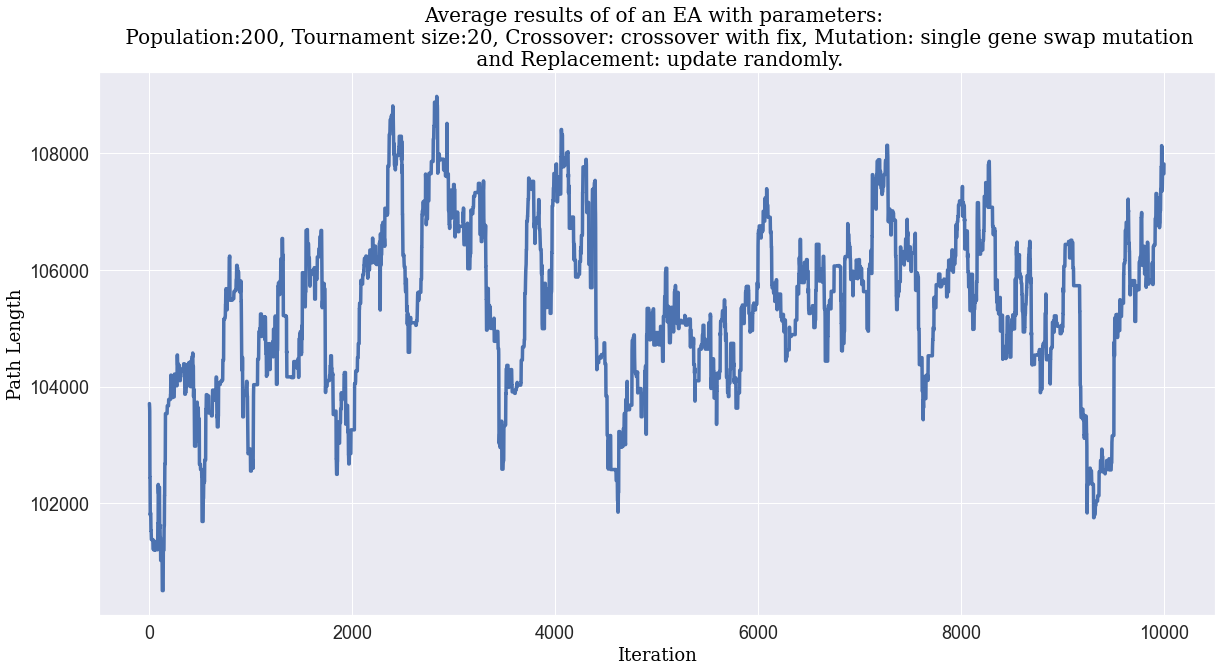

In [253]:
#produces a convergence curve based on the averaged results
font1 = {'family':'serif','color':'Black','size':20}
font2 = {'family':'serif','color':'Black','size':18}
plt.plot([(x) for x in range(0,10001)], solution ,linewidth=3.5, markersize=12)
plt.xlabel("Iteration", fontdict = font2)
plt.ylabel("Path Length", fontdict = font2)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title("Average results of of an EA with parameters: \n Population:200, Tournament size:20, Crossover: crossover with fix, Mutation: single gene swap mutation\n and Replacement: update randomly.", fontdict = font1)
plt.savefig("EA_V64")

Text(0.5, 1.0, 'Average results of of an EA with parameters: \nPopulation:200, Tournament size:20, Crossover: ordered crossover, Mutation: single gene swap mutation\n and Replacement: update randomly.')

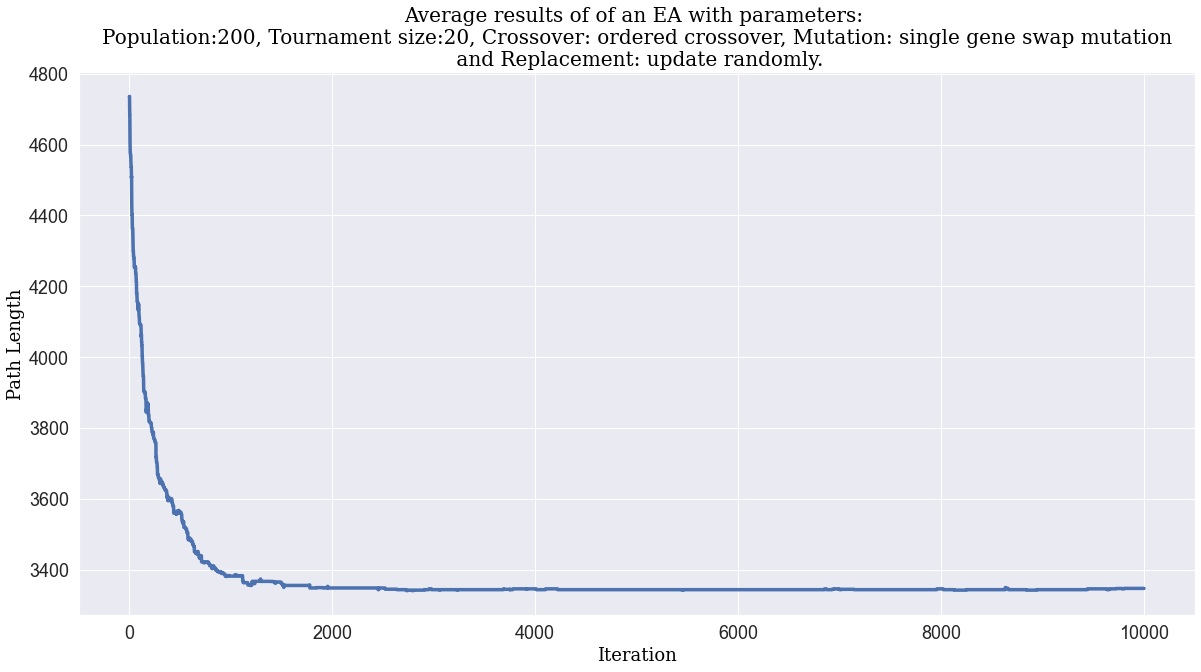

In [259]:
#produces a convergence curve based on the averaged results
font1 = {'family':'serif','color':'Black','size':20}
font2 = {'family':'serif','color':'Black','size':18}
plt.plot([(x) for x in range(0,10001)], solution2 ,linewidth=3.5, markersize=12)
plt.xlabel("Iteration", fontdict = font2)
plt.ylabel("Path Length", fontdict = font2)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title("Average results of of an EA with parameters: \nPopulation:200, Tournament size:20, Crossover: ordered crossover, Mutation: single gene swap mutation\n and Replacement: update randomly.", fontdict = font1)
plt.savefig("EA_V65")

In [274]:
final_path_weight = []
start_path_weight = []
for i in group:
    final_path_weight.append(i[-1])
    start_path_weight.append(i[0])
    

In [282]:
print(final_path_weight)
print(start_path_weight)
difference = []
for i in range(len(final_path_weight)):
    difference.append(start_path_weight[i]-final_path_weight[i])
print(difference[-6]/start_path_weight[-6])

[52122.8, 85680.5, 86144.5, 82767.2, 82478.0, 93900.6, 94878.3, 93651.2, 47864.3, 48624.8, 47966.8, 48197.0, 49842.5, 48147.6, 37551.6, 37516.0, 35898.8, 57898.0, 3807.3, 59587.3, 3827.2, 61339.7, 3572.0, 82271.6, 3720.7, 79140.8, 3601.2, 82429.5, 3621.9, 94494.6, 4058.0, 94206.4, 4072.8, 95438.6, 3970.3, 94886.8, 4088.5, 93187.9, 4053.8, 93858.9, 4078.1, 51184.7, 3342.9, 56524.7, 3923.7, 44287.5, 3354.0, 40943.8, 3328.2, 111794.7, 5051.7, 107819.3, 4863.1, 3346.9]
[104898.4, 106342.7, 104436.5, 106483.8, 103507.9, 106599.5, 105492.3, 104708.3, 105446.5, 104984.5, 103513.4, 104096.2, 106970.0, 103231.1, 106537.9, 104639.4, 104275.8, 106679.7, 5141.7, 105723.0, 4947.3, 102664.3, 4776.5, 104040.1, 5102.2, 106519.7, 4874.5, 101907.3, 4873.3, 107012.4, 4989.8, 105424.5, 5112.2, 102424.2, 4685.9, 108965.2, 5095.1, 105962.0, 4955.7, 104095.9, 4751.2, 101704.5, 4693.9, 108332.7, 4976.9, 105774.7, 4870.6, 102185.6, 4824.5, 106230.4, 5170.5, 103711.3, 4811.1, 4736.0]
0.31014612913255263


## Time analysis

This section is of the time analysis of each of the functions used in the evolutionary algorithm.

In [194]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
result = timeit.timeit(stmt='crossover_with_fix(a,b, matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 0.00010861060000024735 seconds


In [272]:
population, matrix = create_initial_populations("Brazil.xml", 200)

result = timeit.timeit(stmt='select_parents(population, 20)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 5.7030400785151866e-05 seconds


In [283]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
result = timeit.timeit(stmt='crossover_with_fix(a,b, matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 0.00013806700007990003 seconds


In [287]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
result = timeit.timeit(stmt='ordered_crossover(a,b, matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 9.750799799803644e-05 seconds


In [196]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
result = timeit.timeit(stmt='inversion_mutation(c,matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 1.026739992084913e-05 seconds


In [197]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
result = timeit.timeit(stmt='single_swap_mutation(c,matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 1.31665998196695e-05 seconds


In [198]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
result = timeit.timeit(stmt='multi_swap_mutation(c,3,matrix)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 2.9690799783566037e-05 seconds


In [199]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
e = single_swap_mutation(c,matrix)
result = timeit.timeit(stmt='update_first_weakest(population, e)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 1.2868000339949504e-06 seconds


In [200]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
e = single_swap_mutation(c,matrix)
result = timeit.timeit(stmt='update_weakest(population, e)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 2.4617999952170066e-05 seconds


In [202]:
population, matrix = create_initial_populations("Brazil.xml", 200)
a, b = select_parents(population, 20)
c,d = crossover_with_fix(a,b, matrix)
e = single_swap_mutation(c,matrix)
result = timeit.timeit(stmt='update_population(population, e)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 2.0379997295094653e-06 seconds


In [203]:
population, matrix = create_initial_populations("Brazil.xml", 200)
result = timeit.timeit(stmt='best_fitness_evaluation(population)', globals=globals(), number=5)

# calculate the execution time
# get the average execution time
print(f"Execution time is {result / 5} seconds")

Execution time is 2.8496800223365425e-05 seconds
